# Import

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import itertools
from scipy.spatial.distance import euclidean

from IPython.display import Audio, display

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import sounddevice as sd
from scipy.io.wavfile import write

# Feature Engineering 
### Getting MFCC, ZCR, Chroma, Spectral Centroid for every .wav file
### Combining the features with emotion, gender and file name into the CSV file
### Each row contains information regarding to one audio file

In [2]:
emotion_map = {
    1: "neutral",
    2: "calm",
    3: "happy",
    4: "sad",
    5: "angry",
    6: "fearful",
    7: "disgust",
    8: "surprised"
}

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    features = {}

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(1, 14):
        features[f'mfcc{i}'] = np.mean(mfcc[i - 1])

    # Additional Features
    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['chroma'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

    return features

def parse_filename(filename):
    parts = filename.strip('.wav').split('-')
    emotion_code = int(parts[2])
    gender_code = int(parts[6])
    return {
        "emotion": emotion_map.get(emotion_code),
        "gender": "male" if gender_code % 2 != 0 else "female"
    }

def group_emotion(emotion):
    if emotion in ["angry", "sad", "fearful", "disgust", "surprised"]:
        return "urgent"
    else:  # calm, neutral, happy
        return "non-urgent"
    
def plot_spectrogram(file_path, title="", sr=None):
    y, sr = librosa.load(file_path, sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 3))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [3]:
# Get info from all .wav files
data = []
base_dir = 'data'

for root, _, files in os.walk(base_dir):
    for file in tqdm(files):
        if file.endswith('.wav'):
            full_path = os.path.join(root, file)
            meta = parse_filename(file)
            feats = extract_features(full_path)
            feats.update(meta)
            feats['file'] = full_path
            data.append(feats)

# Save into dataframe
df = pd.DataFrame(data)
df["emotion_group"] = df["emotion"].apply(group_emotion)
df.to_csv("data.csv", index=False)

print("Data is saved")

0it [00:00, ?it/s]
C:\Users\i2zel\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\i2zel\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\i2zel\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.23it/s]


Data is saved


## Meaningful Distance between emotions
### Low number = close meaning (in terms of mathematics, not logic!)

In [4]:
df = pd.read_csv("data.csv")

# Removing text columns
non_feature_cols = ["emotion", "emotion_group", "emotion_encoded", "gender", "file"]
feature_cols = df.select_dtypes(include="number").columns.difference(non_feature_cols)

# Grouping emotions
grouped = df.groupby("emotion")[feature_cols].mean()

# Evaluation of Euclidean Distance for each emotion pair
distances = []
for emo1, emo2 in itertools.combinations(grouped.index, 2):
    vec1 = grouped.loc[emo1].values
    vec2 = grouped.loc[emo2].values
    dist = euclidean(vec1, vec2)
    distances.append({
        "Emotion 1": emo1,
        "Emotion 2": emo2,
        "Euclidean Distance": dist
    })

# Result
dist_df = pd.DataFrame(distances).sort_values(by="Euclidean Distance")
print(dist_df)

   Emotion 1  Emotion 2  Euclidean Distance
11      calm        sad           49.916255
18   fearful      happy           72.926202
16   disgust        sad           78.729831
3      angry      happy           80.175790
7       calm    disgust          106.577642
2      angry    fearful          107.183506
26   neutral  surprised          118.320495
14   disgust      happy          137.618469
1      angry    disgust          159.548426
27       sad  surprised          173.161733
12      calm  surprised          205.613028
13   disgust    fearful          210.133062
23     happy        sad          213.601191
9       calm      happy          226.651558
17   disgust  surprised          227.478188
25   neutral        sad          233.854378
5      angry        sad          236.980612
10      calm    neutral          243.751108
0      angry       calm          264.161931
20   fearful        sad          285.902818
8       calm    fearful          296.386318
15   disgust    neutral         

## Spectrograms & Audio

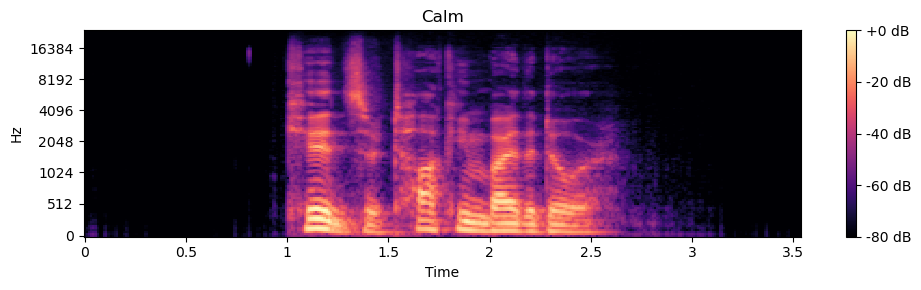

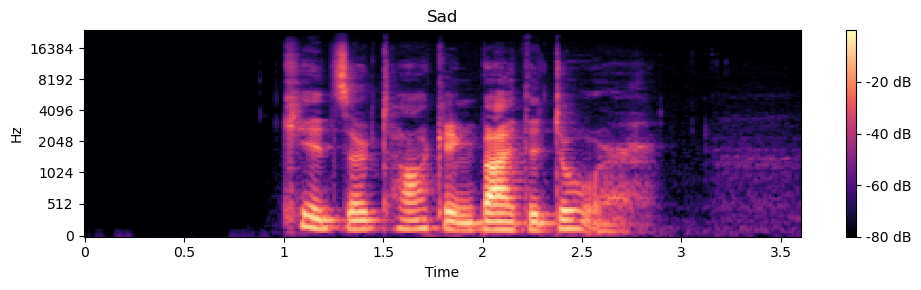

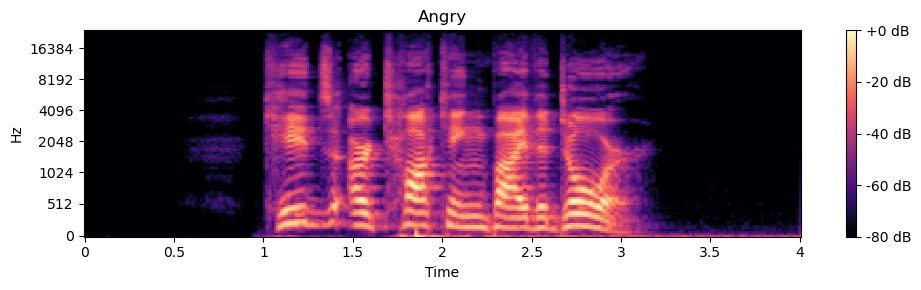

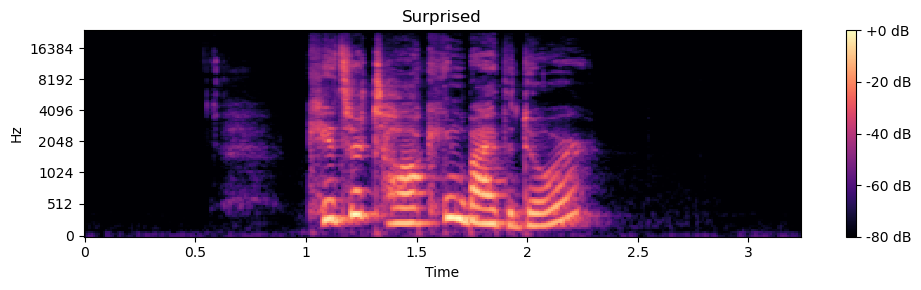

In [5]:
plot_spectrogram("data/Actor_01/03-01-02-01-01-01-01.wav", title="Calm")
plot_spectrogram("data/Actor_03/03-01-04-01-01-01-03.wav", title="Sad")
plot_spectrogram("data/Actor_07/03-01-05-01-01-01-07.wav", title="Angry")
plot_spectrogram("data/Actor_10/03-01-08-01-01-01-10.wav", title="Surprised")

In [6]:
display(Audio("data/Actor_01/03-01-02-01-01-01-01.wav"))  # Calm
display(Audio("data/Actor_03/03-01-04-01-01-01-03.wav"))  # Sad
display(Audio("data/Actor_07/03-01-05-01-01-01-07.wav"))  # Angry
display(Audio("data/Actor_10/03-01-08-01-01-01-10.wav"))  # Surprised

# Model
## Preparation

In [7]:
df = pd.read_csv("data.csv")

le = LabelEncoder()
df["emotion_encoded"] = le.fit_transform(df["emotion_group"])

# Split
X = df.drop(columns=["emotion_group", "emotion_encoded", "emotion", "gender", "file"])
Y = df["emotion_encoded"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

## Random Forest

In [8]:
# Train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

# Predict
Y_pred = rf_model.predict(X_test)

# Accuracy
acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy Random Forest: {acc:.2%}")

Accuracy Random Forest: 79.86%


## Feature Importance & Confusion Matrix

C:\Users\i2zel\AppData\Local\Temp\ipykernel_21376\538544935.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=Random_Forest_importance.values, y=Random_Forest_importance.index, palette="Blues_d")


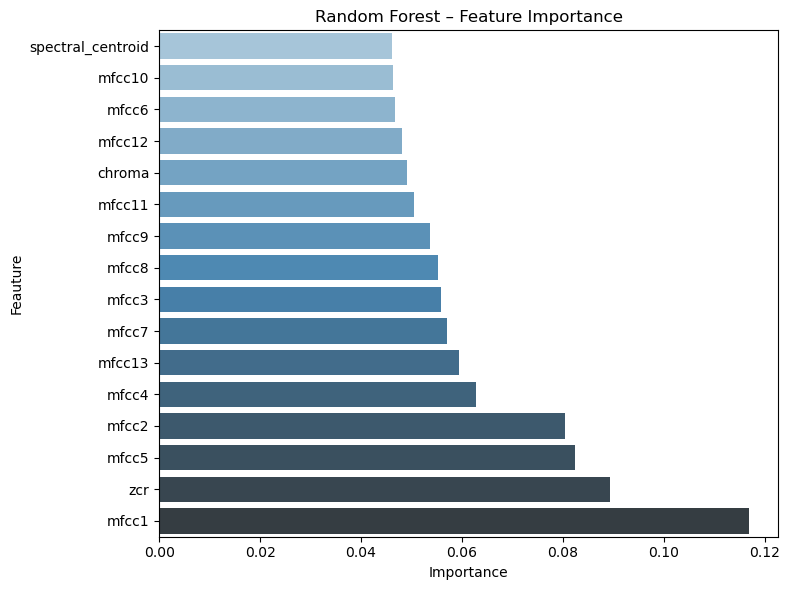

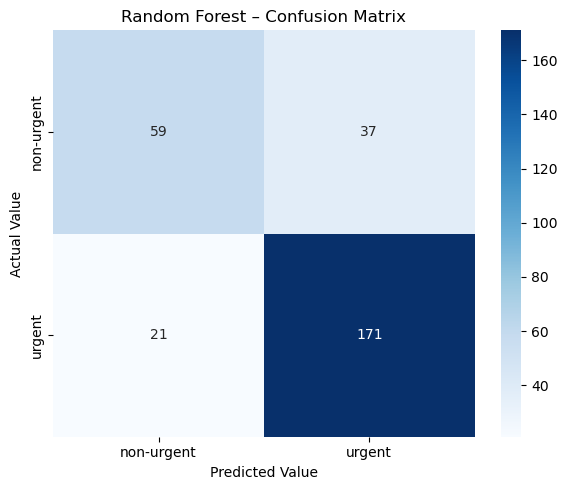

In [9]:
# Feature Importance
Random_Forest_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(x=Random_Forest_importance.values, y=Random_Forest_importance.index, palette="Blues_d")
plt.title("Random Forest – Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feauture")
plt.tight_layout()
plt.show()

# Confusion Matrix
Random_Forest_conf_matrix = confusion_matrix(Y_test, Y_pred)
labels = le.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(Random_Forest_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Random Forest – Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.tight_layout()
plt.show()

## XGBoost

In [10]:
# Train
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=2,
    n_estimators=100,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train, Y_train)

# Predict
Y_pred = xgb_model.predict(X_test)

# Accuracy
acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy XGBoost: {acc:.2%}")

Accuracy XGBoost: 79.51%


## Feature Importance & Confustion Matrix

C:\Users\i2zel\AppData\Local\Temp\ipykernel_21376\1223740098.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=XGBoost_importance.values, y=XGBoost_importance.index, palette="Blues_d")


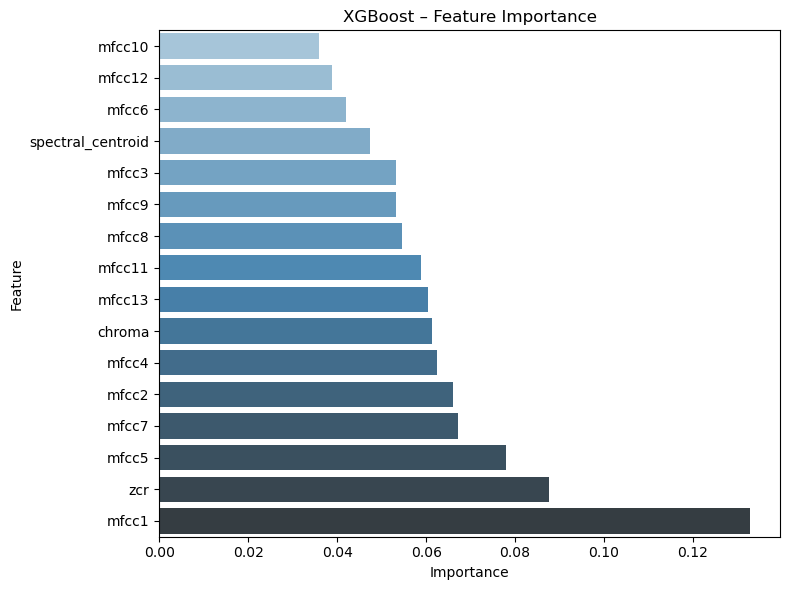

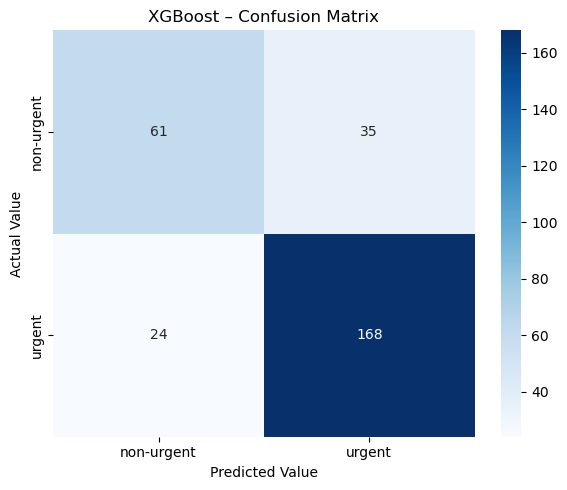

In [11]:
# Feature Importance
XGBoost_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(x=XGBoost_importance.values, y=XGBoost_importance.index, palette="Blues_d")
plt.title("XGBoost – Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Confusion Matrix
XGB_conf_matrix = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(XGB_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("XGBoost – Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.tight_layout()
plt.show()

# Testing

In [49]:
# Recording
fs = 22050
duration = 5

print("Speak...")
audio = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()

write("test.wav", fs, audio)
print("Saved as test.wav")

Speak...
Saved as test.wav


In [50]:
# Getting features
y, sr = librosa.load("test.wav", sr=22050)

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
mfcc_mean = np.mean(mfcc, axis=1)

chroma = librosa.feature.chroma_stft(y=y, sr=sr)
chroma_mean = np.mean(chroma)

zcr = librosa.feature.zero_crossing_rate(y)
zcr_mean = np.mean(zcr)

centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
centroid_mean = np.mean(centroid)

X_test = np.concatenate([mfcc_mean, [chroma_mean, zcr_mean, centroid_mean]])
X_test = X_test.reshape(1, -1)

In [51]:
# Predict
Y_pred = rf_model.predict(X_test)[0]
label = le.inverse_transform([Y_pred])[0]

# Result and decision
if label == "urgent":
    print("Decision:", label, "-> should be forwarded to an operator")
else:
    print("Decision:", label, "-> bot can keep working")

Decision: non-urgent -> bot can keep working


C:\Users\i2zel\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [20]:
display(Audio("test.wav"))